# CAPTCHA recognition with deep learning

_By Yael Rosenfelder (203329784) and Tom Talpir (311206965)_

## Intro

#### What is CAPTCHA?
CAPTCHA stands for __`completely automated public Turing test to tell computers and humans apart`__ and is a type of test used in computing to determine whether or not the user is human.

Over the years, CAPTCHA tasks have evolved from fairly simple tasks to more and more complicated ones.

For example, a textual form of CAPTCHA requires someone to correctly evaluate and enter a sequence of letters or numbers which can be seen in a distorted image displayed on their screen.

**Our goal is to convert textual CAPTCHA images into an actual computer string**

# RESULTS

# DISCUSSION

# CONCLUSION

# 1. Discussion

In this section, we'll adress
1. __Our approach__ - How do we plan to solve this issue?
2. __Tools__
3. __Assumptions and limitations__
4. __The data__ - What kind of data we use & how it's processed
5. __The algorithms__ - A deep dive into the algorithms behind our approaches - 
 * Using Convolutional & Recurrent Neural Networks
 * Using object detection methods (YOLO)

## 1.1. Our approach

Our end-goal is to create a model that learns how to convert CAPTCHA images containing a sequence of characters into actual text, based on labeled examples.

We'll use Deep Learning techniques to learn our images, and we'll describe those techniques in depth in a few chapters.

First, we'll try to tackle the detection of **single letters**. <br> 
We'll treat this as some kind of "Proof-of-concept" - we'll get our hands dirty with convolutional neural networks and working with the data.

Once we manage to classify single letter images, we'll move on to our main task - converting images containing a **full sequence of characters**, into a string. <br>
We'll use 2 different approaches - We'll build our own <u>Recurrent Neural Network</u>, and we'll use a pre-built <u>object detection model</u>.

## 1.2. Tools

We used several different Python-based tools, mainly - 
* __PyTorch__ - Our deep learning framework, used to train our models
* __PIL & OpenCV__ - for processing images __(TODO Yael - Is OpenCV used in the final solution?)__
* __Seaborn & Matplotlib__ - Visualizing our results
* __Pandas__ - For keeping track of our data and their labels, as well as processing the model results
* __YOLO__ - __TODO - Yael explain about this__
* __Google Colab__ - We used Colab for training our models with a GPU

## 1.3. Assumptions & limitations

There are a few limitations to our solution, that we're aware of even before getting started - 
1. __Lack of GPU__ - Both of us don't own a GPU. Training neural networks without GPU's is excruciatingly slow, so we're using Google Colab's free GPU, which has many limitations - It doesn't have a persistent disk, the environment shuts down after 12 hours, and after a few long training sessions it won't allow a GPU allocation for several hours.
<br><br>
2. __Reduced vocabulary__ - Considering the previous constraint, we decided to reduce the vocabulary that we're using for every approach. In certain methods we only allow digits, in some we'll accept the entire lowercase English alphabet, and in our last approach we tried combining both digits & lowercase English letters.
<br><br>
3. __Limited string length__ - Another practical assumption that we made, is that our images won't exceed a certain amount of characters. For our RNN approach, we assume that an image will contain between 5-10 characters.

## 1.4. The Data

In [206]:
from IPython.display import Image

We'll begin by manually generating images, using 2 Pythonic libraries - __PyCaptcha__ & __Claptcha__.

We chose to use 2 different generation libraries, so that our model won't specifically learn one type of CAPTCHA generation mechanism. <br>
We thoroughly read the codebase for these generation library, and their approach is very straightforward - <br>
They both <u>randomly select characters</u> from a vocabulary (for example - Lowercase English alphabet), and then <u>randomly place the characters one after the other</u>, creating certain <u>overlap</u> & angular <u>rotations</u>. 
Finally, they both arbitrarliy add <u>noise</u> to the image.

__PyCaptcha__ creates images with a lot of background noise, and the characters themselves are a bit _"Pixelated"_

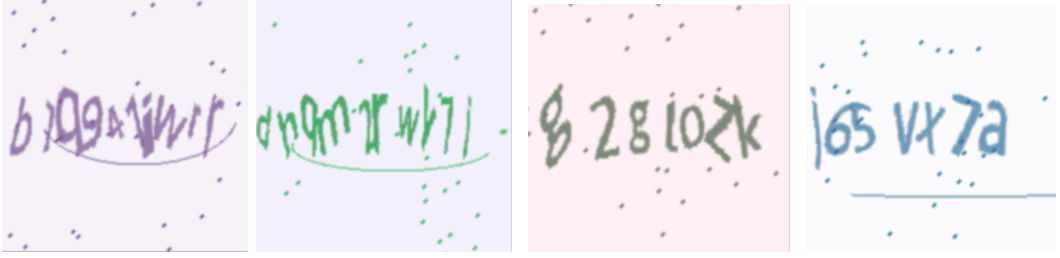

In [207]:
Image("./assets/pycaptcha_sample.png")

__Claptcha__ creates less pixelated images, with much more character rotation. Also, the characters appear to be much more distorted.

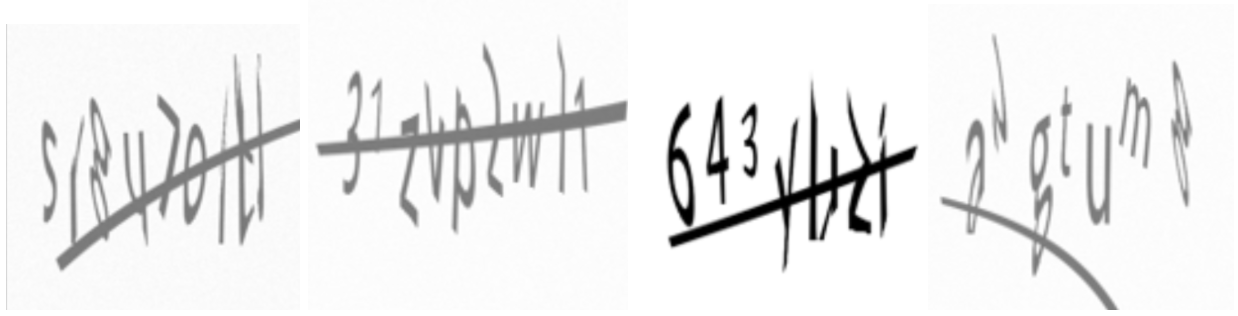

In [209]:
Image("./assets/claptcha_sample.png")

### 1.4.1. Dataset size & info

As we previously explained, we picked different datasets for each approach. <br>
Each approach had different constraints which we'll elaborate on.

__<u> Single letter images</u>__
1. 40,000 training images
2. 5,000 test images
3. Vocabulary - The entire lowercase English alphabet (`a, b, c, ..., z`). 
4. Each character has an equal probability of appearing in an image (26 possibilities)
5. Only PyCaptcha was used
6. Each image is of size `(80, 80)`


__<u> Multiple character images (RNN approach)</u>__
1. 50,000 training images
2. 5,000 test images
3. Vocabulary - The entire lowercase English alphabet (`a, b, c, ..., z`) and digits (`0, 1, ..., 9`)
4. Each character has an equal probability of appearing in an image (36 possibilities)
5. A sequence can have between 5-10 characters. We randomly pick the length every time we generate
6. Both PyCaptcha & Claptcha were used
7. Each image is of size `(289, 289)`


__<u> Multiple character images (YOLO approach)</u>__
<br>
__TODO - YAEL (should also note that these images were manually tagged!)__

### 1.4.2. Processing the data

Our images are created as `.PNG` files, and are loaded via `PIL`. 

Each image is then represented as a NumPy 3-dimensional array of size `(W, H, 3)` _(RGB - 3 channels)_ . <br>
Every value in this array is an integer between `0` and `255`, representing the pixel intensity for every part of the image.

The next step is to __normalize__ our input, so that each values is in the range `[0, 1]`. <br>
We'll also normalize the mean & standard deviation of the values across every channel

There are 2 reasons for normalizing our input - 
1. This is considered to be a best practice in image processing & deep learning. <br>
One possible reason is the <u>vanishing gradient problem</u> - The gradients become increasingly small, which makes it harder for gradients to pass through the network and update the weights. We won't go into this problem here, but decreasing the range of values of our input might help with this issue.
2. In some of our approaches, we're using <u>Transfer Learning</u>. Certain architectures require the images to be normalized in a specific way.

The values will be normalized to the `[0, 1]` range by adjusting each value - 
<br> <br>
$$ x_{new} = \frac{x_{old} - Min}{Max - Min} = \frac{x_{old} - 0}{255 - 0} $$

<br> 
Where Max is `255` and Min is `0` - the limits of our pixel intensity range.
<br> <br>
As for normalizing the mean & std, there are several approaches. One is to decrease from each channel it's mean value and divide by the standard deviation, or center the values around a `0` mean.
<br>

We'll use a more specific approach, dictated by the ResNet requirements in PyTorch.
Each pixel value will be normalized as follows -
<br><br>
$$ x_{new} = \frac{x_{old} - mean}{stdev}$$

## Data creation

In [1]:
from PIL import Image
from random import choices
from captcha.image import ImageCaptcha
from claptcha import Claptcha
import string
import random
import uuid
import glob
import datetime
import os

### Single letters
Like we explained earlier, we're going to begin with gener

In [7]:
class SingleLetterImageGenerator():
    def __init__(self):
        self._fonts = self.font_finder()
    
        self._base_dir_name = "single_char_generated_images_{dt}".format(dt=datetime.datetime.now().strftime("%s"))
        # Create the base dir we're gonna save our generated images in
        os.mkdir(self._base_dir_name)
        
        self.captcha_generator = ImageCaptcha(fonts=self._fonts, width=80, height=80)
        self.base_chars = string.ascii_lowercase
        
    def font_finder(self):
        """
        Returns a list of all fonts in the `fonts` dir of this project
        """
        return glob.glob('/Users/tomtalpir/dev/tom/captcha_project/CaptchaImgGeneration/fonts/*.ttc')
        
    def generate_single_char(self):
        """
        Randomly select a character from the base chars
        """
        selected_char = random.choice(self.base_chars)
        return selected_char
    
    def generate_captcha_image(self, char):
        """
        Receive a single character, and creates a CAPTCHA image, and returns the generated file name
        """
        random_id = str(uuid.uuid4())[-8:]
        filename = "./{dirname}/{char}_{random_id}.png".format(dirname=self._base_dir_name, char=char, random_id=random_id)
        self.captcha_generator.write(char, filename)
        return filename
    
    def execute_img_generation(self, num_of_images=10):
        """
        Generate N CAPTCHA images, N received as a parameter.
        Each image is saved as a PNG file
        """
        print("Writing results to {d}".format(d=self._base_dir_name))
        for i in range(num_of_images):
            print("Running generation number #{i}".format(i=i+1))
            char = self.generate_single_char()
            fname = self.generate_captcha_image(char)

In [203]:
single_generator = SingleLetterImageGenerator()
single_generator.execute_img_generation(num_of_images=10)

Writing results to generated_images_1592145684
Running generation number #1
Running generation number #2
Running generation number #3
Running generation number #4
Running generation number #5
Running generation number #6
Running generation number #7
Running generation number #8
Running generation number #9
Running generation number #10


### Multiple letters (full strings)

In [54]:
class FullStringImageGenerator():
    def __init__(self, vocab=string.digits):
    
        self._base_dir_name = "full_string_generated_images_{dt}".format(dt=datetime.datetime.now().strftime("%s"))

        # Create the base dir we're gonna save our generated images in
        os.mkdir(self._base_dir_name)
        
        self._fonts = self.font_finder()
        self.img_w = 200
        self.img_h = 200

        self.captcha_generator = ImageCaptcha(width=self.img_w, height=self.img_h, fonts=self._fonts)
        self.vocab = string.ascii_lowercase + string.digits

        self.n_min_chars = 5
        self.n_max_chars = 10
        
    def font_finder(self):
        """
        Returns a list of all fonts in the `fonts` dir of this project
        """
        return glob.glob('/Users/tomtalpir/dev/tom/captcha_project/CaptchaImgGeneration/fonts/*.ttc')
        
    def generate_captcha_sequence(self):
        """
        Randomly create a CAPTCHA sequence
        """
        captcha = ""
        captcha_length = random.randint(self.n_min_chars, self.n_max_chars)
        for x in range(captcha_length):
            captcha += random.choice(self.vocab)

        return captcha
    
    def select_captcha_generator(self):
        """
        Select the type of Captcha generator we'll use
        1 = PyCaptcha, Pr(x) = 0.6
        2 = Claptcha, Pr(x) = 0.4
        """
        population = [1, 2]
        weights = [0.6, 0.4]

        return choices(population, weights)[0]
    
    def generate_pycaptcha_image(self, sequence):
        """
        Receive a CAPTCHA sequence (string), creates a CAPTCHA image, and returns the generated file name.
        Using PyCaptcha to generate
        """
        random_id = str(uuid.uuid4())[-8:]
        filename = "./{dirname}/{sequence}_{random_id}.png".format(dirname=self._base_dir_name, sequence=sequence, random_id=random_id)
        self.captcha_generator.write(sequence, filename)
        return filename

    def generate_claptcha_image(self, sequence):
        """
        Receive a CAPTCHA sequence (string), creates a CAPTCHA image, and returns the generated file name.
        Using Calptcha to generate
        """
        random_id = str(uuid.uuid4())[-8:]
        filename = "./{dirname}/{sequence}_{random_id}.png".format(dirname=self._base_dir_name, sequence=sequence, random_id=random_id)
        
        noise_level = round(random.uniform(0.0, 0.1), ndigits=3) # Randomly select a noise level for our generation, from a uniform distribution
        c = Claptcha(sequence, self._fonts[0], (self.img_w / 1.5, self.img_h / 1.5), noise=noise_level, resample=Image.BICUBIC)
        c.write(filename)
        return filename
    
    def execute_img_generation(self, num_of_images=10):
        """
        Generate N CAPTCHA images, N received as a parameter.
        Each image is saved as a PNG file
        """
        print("Writing results to {d}".format(d=self._base_dir_name))
        for i in range(num_of_images):
            gen_type = self.select_captcha_generator()
            print("Running generation number #{i} (type = {t})".format(i=i+1, t=gen_type))
            sequence = self.generate_captcha_sequence()

            if gen_type == 1: # PyCaptcha
                self.generate_pycaptcha_image(sequence)
            elif gen_type == 2: # Claptcha
                self.generate_claptcha_image(sequence)


In [204]:
full_generator = FullStringImageGenerator()
full_generator.execute_img_generation(num_of_images=5)

Writing results to full_string_generated_images_1592145712
Running generation number #1 (type = 1)
Running generation number #2 (type = 2)
Running generation number #3 (type = 2)
Running generation number #4 (type = 1)
Running generation number #5 (type = 1)


In [170]:
mv full_string_generated_images_1591985170/ full_strings_50k_train

In [171]:
import tarfile
tar = tarfile.open("full_strings_50k_train.tar.gz", "w:gz")
tar.add("full_strings_50k_train/", arcname="full_strings_50k_train")
tar.close()

## Processing the data

Since we're working with PyTorch, we'll use the PyTorch ecosystem to process our data.
We'll begin by normalizing our images, which is **explained in depth in the textual project report.**

In both cases (single chars & full strings) we're representing our data with a PyTorch dataset

In [33]:
import glob
import string
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

#### Metadata reader
A utility that creates a Pandas DF with all the mappings between our images & their label

In [20]:
def get_metadata_df(images_path):
    """
    Returns a Pandas DF containing all the metadata for our PyTorch dataset.
    This DF has 2 columns - An image path and it's label. 
    The label can be one of 62 characters - 26 English letters * 2 (upper/lowercase) + 10 digits = 62

    @param images_path (str) - The path from which image paths will be collected
    @return Pandas DF (<img_path:str>, <label:str>)
    """
    dataset_images = glob.glob("{base_dataset}/*.png".format(base_dataset=images_path))

    images_data_for_df = []
    for img in dataset_images:
        # The path we're getting is the full path - /path/to/img.png. Split by `/` and get the last part - that's our image name!
        filename = img.split("/")[-1] 

        # Our file names are of the following format - <label>_<random_id>.png
        # Extract the char name by splitting via the `_` char
        # For the Kaggle dataset, format is <label>.png
        if "_" in filename: # Our generated images
            label = filename.split("_")[0]
        else: #Kaggle format:
            label = filename.split(".")[0]

        info = {
            "img_path": img,
            "raw_label": label,
        }
        images_data_for_df.append(info)

    df = pd.DataFrame(images_data_for_df)
    return df

#### Image viewer
A utility for showing the images in our dataset

In [48]:
def show_images_from_dataloader(inp, title=None):
    """
    Show an image from a dataloader.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Re-normalize so image looks normal
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Wait for img to load


### Single letters

In [91]:
class SingleLetterCaptchaDataset(Dataset):
    """
    Single letter images dataset, based on the PyTorch Dataset object
    """
    def __init__(self, dataset_metadata_df, labels_mapping, img_size=80):
        """
        @param dataset_metadata_df (Pandas DF) - A DF representing all our metadata for this Dataset - image paths & labels
        @labels_mapping (dict) - A mapping of the vocabulary for our data. 0 --> `a`, 1 --> `b` etc.
        @param img_size (int, default 80) = The size of an input image, assuming it's a square
        """
        self.dataset_metadata_df = dataset_metadata_df
        self.img_size = img_size
        self.labels_mapping = labels_mapping

    def __len__(self):
        return len(self.dataset_metadata_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_metadata = self.dataset_metadata_df.iloc[idx]
        img_path = img_metadata[0]

        char_label = img_metadata[1].lower() # Label from pandas df is a character, for example `b`, `Z`, `3` and so on.
        char_label_idx = self.labels_mapping[char_label]

        image = Image.open(img_path)
        preprocess = transforms.Compose([
            # Resize to fit ResNet requirements
#             transforms.Resize(224), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = preprocess(image)

        return (image, char_label_idx)
  

Create the mapping of labels - map every character in our vocabulary to a numeric value

In [92]:
letters_for_model = list(string.ascii_lowercase)
label_mapping = {}
for i, l in enumerate(letters_for_model):
    label_mapping[l] = i
TOTAL_NUM_OF_CLASSES = len(label_mapping.keys())

In [106]:
single_letter_dataset_path = './generated_images_1591887849/' # 10 samples
single_letter_dataset_path = './generated_images_1591905313/' # 1000 samples
single_letter_metadata_df = get_metadata_df(single_letter_dataset_path)

In [107]:
single_letter_metadata_df.head()

,img_path,raw_label
0,./generated_images_1591905313/m_dd8d07c8.png,m
1,./generated_images_1591905313/w_29e94522.png,w
2,./generated_images_1591905313/d_8ecf0628.png,d
3,./generated_images_1591905313/h_0c25583b.png,h
4,./generated_images_1591905313/p_7121213d.png,p


In [108]:
single_letter_dataset = SingleLetterCaptchaDataset(single_letter_metadata_df, label_mapping)
single_letter_data_loader = torch.utils.data.DataLoader(single_letter_dataset, batch_size=200, shuffle=True)

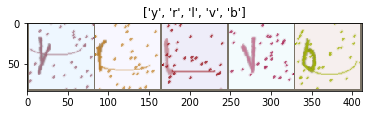

In [112]:
inputs, classes = next(iter(single_letter_data_loader))
inputs = inputs[:5]
classes = classes[:5]
out = torchvision.utils.make_grid(inputs)

show_images_from_dataloader(out, title=[letters_for_model[x] for x in classes])

### Full strings

In [53]:
class LabelConverter():
    """
    A utility for encoding/decoding labels, based on the CTC conventions (idx=0 is the Epsilon (blank) character)
    
    A raw label might be "hello123", and we want to represent it as a Tensor
    """
    def __init__(self, vocab):
        self.vocab = vocab
        
        # The CTC loss function requires idx=0 to be reserved for the blank character, so indexing starts from 1
        self.offset = 1

        # Initialize an index for each char in our vocabulary, with the offset
        self.label_mapping = {}
        for i, v in enumerate(vocab):
            self.label_mapping[v] = i + self.offset
    
    def encode(self, label):
        encodings = []
        for char in label:
            encodings.append(self.label_mapping[char])
        
        return torch.IntTensor(encodings)

    def decode(self, labels_vector):
        txt_label = ""

        for v in labels_vector.tolist():
            if v == 0: # Skip CTC blank characters
                continue
            char = self.vocab[v - self.offset]
            txt_label += char
        
        return txt_label
    
class FullCaptchaDataset(Dataset):
    def __init__(self, dataset_metadata_df, vocab, is_external_img=False):
        self.dataset_metadata_df = dataset_metadata_df
        self.vocab = vocab
        self.label_converter = LabelConverter(self.vocab)
        self.is_external_img = is_external_img
    
    def __len__(self):
        return len(self.dataset_metadata_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_metadata = self.dataset_metadata_df.iloc[idx]
        img_path = img_metadata[0]
        raw_label = img_metadata[1]

        image = Image.open(img_path)

        if self.is_external_img: # Our external dataset has 4 channels (RGBA) and needs to be converted to RGB
            background = Image.new("RGB", image.size, (255, 255, 255))
            background.paste(image, mask=image.split()[3]) # 3 is the alpha channel
            image = background

        preprocess = transforms.Compose([
            transforms.Resize(289),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = preprocess(image)
        label = self.label_converter.encode(raw_label)
        return (image, label)

def model_output_to_label(prediction):
    """
    Receive a list which represents an output from our RNN, and convert it to an actual label.
    Our model has a lot of redundant outputs - The same characters repeated, and a lot of "blank" CTC labels.

    Our goal is to get rid of those characters and return the final label as a PyTorch Tensor

    Example - 
    Input = [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0]
    Output = tensor([1, 1, 1, 2])

    Input = [2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0]
    Output = tensor([2, 2, 2, 1])
    """
    last_value = None
    result = []
    for x in prediction:
        if x != last_value and x > 0:
            result.append(x)
        last_value = x
    
    return torch.IntTensor(result)

def compare_tensors(t1, t2):
    """
    Check whether two tensors are identical
    """
    b = torch.all(t1.eq(t2))
    return bool(b)

def custom_collate_func(data):
    """
    Stack the images as one big tensor, and the labels as a list
    This is done because the labels are tensors of varying sizes, and we're forced to create them as a list instead
    of a tensor
    """
    imgs = torch.stack([x[0] for x in data], dim=0)
    labels = [x[1] for x in data]
    return [imgs, labels]

In [56]:
vocab = string.ascii_lowercase + string.digits
lc = LabelConverter(vocab)

In [163]:
# full_strings_dataset_path = './full_string_generated_images_1591902599' # 10 sample
full_strings_dataset_path = './full_string_generated_images_1591982940' # 1000 sample

full_strings_dataset_metadata_df = get_metadata_df(full_strings_dataset_path)

In [164]:
full_strings_dataset_metadata_df.head()

,img_path,raw_label
0,./full_string_generated_images_1591982940/tko2...,tko24
1,./full_string_generated_images_1591982940/40mf...,40mfr49
2,./full_string_generated_images_1591982940/95f0...,95f0z
3,./full_string_generated_images_1591982940/1ddw...,1ddw67
4,./full_string_generated_images_1591982940/8u9u...,8u9u2dbnpx


In [165]:
full_captcha_dataset = FullCaptchaDataset(full_strings_dataset_metadata_df, vocab)
full_captcha_dataset_loader = torch.utils.data.DataLoader(full_captcha_dataset, batch_size=200, shuffle=True, collate_fn=custom_collate_func)

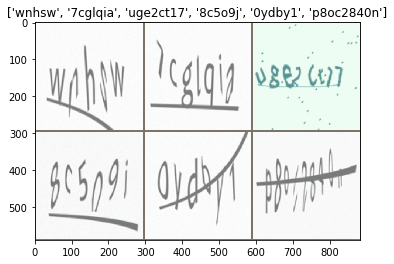

In [205]:
inputs, classes = next(iter(full_captcha_dataset_loader))
inputs = inputs[:6]
classes = classes[:6]
classes_as_str = []
for c in classes:
    classes_as_str.append(lc.decode(c))
out = torchvision.utils.make_grid(inputs, scale_each=True, normalize=False, padding=4, nrow=3)


show_images_from_dataloader(out, title=classes_as_str)

## Models!

In [121]:
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns # Visualize loss & accuracy

### Single Letter Network

We tried creating our very simple and shallow ConvNet - 3 conv layers, and 3 FC layers to reduce the size. BatchNorm between layers.

**The selected architecture is discussed in depth in the additional project report.**

In [116]:
class SingleLetterCaptchaDeepCNN(nn.Module):
    def __init__(self, TOTAL_NUM_OF_CLASSES):
        super(SingleLetterCaptchaDeepCNN, self).__init__()
        
        self.conv1_layer = nn.Conv2d(3, 16, 3) 
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2_layer = nn.Conv2d(16, 20, 3)
        self.conv2_bn = nn.BatchNorm2d(20)

        self.conv3_layer = nn.Conv2d(20, 10, 3)
        self.conv3_bn = nn.BatchNorm2d(10) 

        self.layer_size_after_convs = 10 * 8 * 8
        self.fc1 = nn.Linear(self.layer_size_after_convs, self.layer_size_after_convs // 4) # Training on several labels instead
        self.fc1_bn = nn.BatchNorm1d(self.layer_size_after_convs // 4) 
        self.fc2 = nn.Linear(self.layer_size_after_convs // 4, self.layer_size_after_convs // 8) # Training on several labels instead
        self.fc2_bn = nn.BatchNorm1d(self.layer_size_after_convs // 8) 
        self.fc3 = nn.Linear(self.layer_size_after_convs // 8, TOTAL_NUM_OF_CLASSES) # Training on several labels instead
    
    
    def forward(self, x):
        """
        Perform a forward pass on the network
        """
        x = self.conv1_layer(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        x = self.conv2_layer(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        x = self.conv3_layer(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        
        # Reshape tensor so that it's still in batches, but each conv result is now one big vector
        x = x.view(-1, self.layer_size_after_convs)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [118]:
model = SingleLetterCaptchaDeepCNN(TOTAL_NUM_OF_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.00000001)

## TODO - DO WE INCLUDE THIS???

In [117]:
dataloaders = {
    'train': train_dataset_loader,
    'val': test_dataset_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(test_dataset)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

NameError: name 'train_dataset_loader' is not defined

In [88]:
num_epochs = 100
for epoch in range(num_epochs):
    since = time.time()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            # continue
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        time_elapsed = time.time() - since
        print('Epooch took {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        

In [120]:
single_letter_epochs_data = [
    [0, "train", 3.0570, 0.1300], [0, "val", 3.2081,  0.0728], 
    [1, "train", 2.7597, 0.2624], [1, "val", 2.8997,  0.1975], 
    [2, "train", 2.4909, 0.3948], [2, "val", 2.6107,  0.3425], 
    [3, "train", 2.2451, 0.4960], [3, "val", 2.3532,  0.4574], 
    [4, "train", 2.0132, 0.6018], [4, "val", 2.1137,  0.5566], 
    [5, "train", 1.7967, 0.6802], [5, "val", 1.8860,  0.6443], 
    [6, "train", 1.5931, 0.7506], [6, "val", 1.6761,  0.7176], 
    [7, "train", 1.4015, 0.8018], [7, "val", 1.4844,  0.7772], 
    [8, "train", 1.2492, 0.8412], [8, "val", 1.3114,  0.8280], 
    [9, "train", 1.1037, 0.8784], [9, "val", 1.1596,  0.8642], 
    [10, "train", 0.9872, 0.8964], [10, "val", 1.0285, 0.8859], 
    [11, "train", 0.8737, 0.9080], [11, "val", 0.9118, 0.9048], 
    [12, "train", 0.7861, 0.9204], [12, "val", 0.8114, 0.9204], 
    [13, "train", 0.6992, 0.9302], [13, "val", 0.7225, 0.9316], 
    [14, "train", 0.6273, 0.9444], [14, "val", 0.6480, 0.9411], 
    [15, "train", 0.5646, 0.9508], [15, "val", 0.5805, 0.9478], 
    [16, "train", 0.5117, 0.9572], [16, "val", 0.5224, 0.9548], 
    [17, "train", 0.4601, 0.9614], [17, "val", 0.4718, 0.9601], 
    [18, "train", 0.4193, 0.9666], [18, "val", 0.4254, 0.9655], 
    [19, "train", 0.3783, 0.9704], [19, "val", 0.3852, 0.9689], 
    [20, "train", 0.3470, 0.9728], [20, "val", 0.3482, 0.9701], 
    [21, "train", 0.3153, 0.9752], [21, "val", 0.3163, 0.9695], 
    [22, "train", 0.2873, 0.9784], [22, "val", 0.2919, 0.9709]
]

In [122]:
df = pd.DataFrame(single_letter_epochs_data, columns=["epoch", "type", "loss", "acc"])

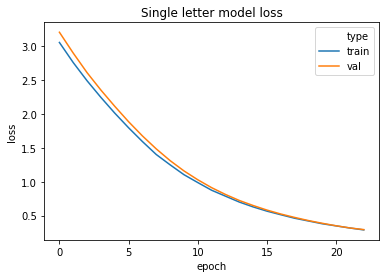

In [125]:
sns.lineplot(x="epoch", y="loss", hue="type", data=df).set_title("Single letter model loss")
plt.show()

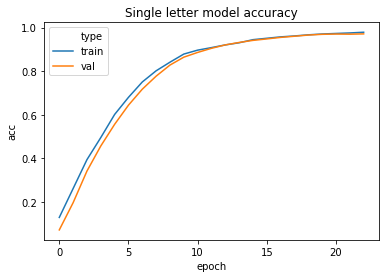

In [126]:
sns.lineplot(x="epoch", y="acc", hue="type", data=df).set_title("Single letter model accuracy")
plt.show()

### Let's test the model on the newly generated data!

In [127]:
single_letter_model_path = "single_letter_captcha_model_final_11062020.pth"
single_letter_model.load_state_dict(torch.load(single_letter_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [128]:
single_letter_model.eval()
total_test_samples = len(single_letter_dataset)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in single_letter_data_loader:
        outputs = single_letter_model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print('Test Accuracy of the model on the {count} test images: {acc}'.format(count=total_test_samples, acc = accuracy))


Test Accuracy of the model on the 1000 test images: 95.7


### Full strings model

In [189]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F

class ConvRNN(nn.Module):
    def __init__(self, target_size):
        super(ConvRNN, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]

        self.resnet = nn.Sequential(*modules)
        
        #### Don't optimize resnet
        for p in self.resnet.parameters():
            p.requires_grad = False

        #### Optimize the last 2 blocks
        for c in list(self.resnet.children())[-2:]:
            for p in c.parameters():
                p.requires_grad = True


        self.cnv = nn.Conv2d(512, 512, 2)
#         self.rnn = nn.RNN(512, 256, 1, batch_first=True) 
        self.rnn = nn.LSTM(512, 256, 1, batch_first=True) 
        
        # self.small_fc = nn.Linear(256, target_size)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, target_size)
#         self.fc4 = nn.Linear(64, target_size)

        # self.small_fc.bias.data.fill_(0)
        # self.small_fc.weight.data.uniform_(-0.1, 0.1)

        self.fc1.bias.data.fill_(0)
        self.fc1.weight.data.uniform_(-0.1, 0.1)
        self.fc2.bias.data.fill_(0)
        self.fc2.weight.data.uniform_(-0.1, 0.1)
        self.fc3.bias.data.fill_(0)
        self.fc3.weight.data.uniform_(-0.1, 0.1)
#         self.fc4.bias.data.fill_(0)
#         self.fc4.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        encoded_img = self.resnet(x)
        # encoded_img = resnet(x)
        encoded_img = F.max_pool2d(self.cnv(encoded_img), (2,2))
        # encoded_img = F.max_pool2d(cnv(encoded_img), (2,2))
        encoded_img = F.relu(encoded_img)

        batch_size = encoded_img.size(0)
        features = encoded_img.size(1)
        encoded_img = encoded_img.view(batch_size, -1, features)

        rnn_outputs, h = self.rnn(encoded_img)
        
        rnn_seq_len = rnn_outputs.size(1)

        fc_outputs = []
        for seq_idx in range(rnn_seq_len):
            
            # output = self.small_fc(rnn_outputs[:, seq_idx, :])
            output = self.fc1(rnn_outputs[:, seq_idx, :])
            output = F.relu(output)

            output = self.fc2(output)
            output = F.relu(output)

            output = self.fc3(output)
#             output = F.relu(output)

#             output = self.fc4(output)

            fc_outputs.append(output)

        outputs = torch.stack(fc_outputs).log_softmax(2) # Outputs is of shape seq_len * batch_size * class_num (which is what CTC expects)

        return outputs

In [190]:
T = 16 # Input sequence length, as determined by our encoded img and inserted to our RNN
C = len(vocab) + 1 # Number of classes. Add 1 for a blank label
N = 200 # Batch size
inputs_len = tuple([T for n in range(N)]) # This is because basically a `N`-sized Tensor, with `T` as all it's values.

full_strings_model = ConvRNN(target_size=C)
optimizer = torch.optim.Adam(full_strings_model.parameters(), lr=0.00005, weight_decay=0.00000001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_strings_model = full_strings_model.to(device)
criterion = nn.CTCLoss()

# THIS IS THE TRAINING PART. TODO - INCLUDE?!

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    since = time.time()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            # continue
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        # Iterate over data.

        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            
            targets = torch.cat(labels)
            targets_len = tuple([len(l) for l in labels])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)

                # _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets, inputs_len, targets_len)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            if i % 20 == 19 and phase == 'train':    # print loss after several minibatches
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))

        prediction = []
        for b in range(4): # Print the first 5 predictions
            single_element_pred = []
            for t in outputs.data:
                _, pred = torch.max(t[b].data, 0)
                single_element_pred.append(int(pred))
            prediction.append(single_element_pred)

        for i, pred in enumerate(prediction):
            prediction_tensor = model_output_to_label(pred)
            model_pred = lc.decode(prediction_tensor)
            real_label = lc.decode(labels[i])
            print("{i}. Pred = {p}, real = {r} ".format(i=i+1, p=model_pred, r=real_label))

        epoch_loss = running_loss / dataset_sizes[phase]
        # epoch_acc = running_corrects.double() / dataset_sizes[phase]
        time_elapsed = time.time() - since
        print('#### Epooch took {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('#### {} Loss: {:.4f}'.format(phase, epoch_loss))




In [192]:
# full_strings_model_path = "full_string_rnn_ctc_model_12062020.pth"
# full_strings_model_path = "/Users/tomtalpir/Downloads/1layer_rnn_3fc_10_chars_lowerascii_digits_13.pth"
full_strings_model_path = "/Users/tomtalpir/Downloads/1layer_lstm_3fc_10_chars_lowerascii_digits_12.pth"

full_strings_model.load_state_dict(torch.load(full_strings_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [159]:
from fuzzywuzzy import fuzz

In [200]:
full_strings_model.eval()
predictions_info = []
with torch.no_grad():
    correct = 0
    partial_correct = 0
    total = 0
    for images, labels in full_captcha_dataset_loader:
        targets = torch.cat(labels)
        outputs = full_strings_model(images)
        prediction = []
        for b in range(len(labels)):
            single_element_pred = []
            for t in outputs.data:
                _, pred = torch.max(t[b].data, 0)
                single_element_pred.append(int(pred))
            prediction.append(single_element_pred)

        for i, pred in enumerate(prediction):
            prediction_tensor = model_output_to_label(pred)
            model_pred = lc.decode(prediction_tensor)
            real_label = lc.decode(labels[i])
            total += 1
            fuzz_dist = fuzz.ratio(model_pred, real_label) / 100
            partial_fuzz_dist = fuzz.partial_ratio(model_pred, real_label) / 100
            correct += fuzz_dist
            partial_correct += partial_fuzz_dist
            predictions_info.append({"label": real_label, "pred": model_pred})
            # if compare_tensors(prediction_tensor, labels[i]):
            #     correct += 1
            print("{i}. Pred = {p}, real = {r} ".format(i=i+1, p=model_pred, r=real_label))

    print()
    print("fuzzy ratio = {correct}/{total} = {val}%".format(correct=correct, total=total, val=float(correct) / total))
    print("partial_ratio = {correct}/{total} = {val}%".format(correct=partial_correct, total=total, val=float(partial_correct) / total))


1. Pred = 17xpcj, real = 17xqcj 
2. Pred = p7ku91u, real = p7yu9tl 
3. Pred = pn63a, real = pn63a 
4. Pred = fd0ceu, real = fdoseu 
5. Pred = ck7892nqe, real = qt789cpzo 
6. Pred = h7azk8, real = h7a7k8 
7. Pred = zwrcc7x, real = zw4qc7y 
8. Pred = 3o6zw, real = 3o6zw 
9. Pred = 045qfj, real = o46pfj 
10. Pred = ykdxx2mwy, real = ykdvv2uwdy 
11. Pred = 1zab4, real = 17ab4 
12. Pred = logzio, real = uelgzi0 
13. Pred = 32yn7r7tce, real = 32yn1lzfde 
14. Pred = usfa, real = uscta 
15. Pred = 75waqqcl, real = 7awan0sl 
16. Pred = lat1z7, real = latlz7 
17. Pred = 1galt44m, real = 1gallnm 
18. Pred = 054adb6, real = o5hau6 
19. Pred = 2vu2w3vk, real = 2lkczw3vv 
20. Pred = 517y3, real = 51ry3 
21. Pred = 0wl4ta3v, real = 0w14ra3v 
22. Pred = 73orfo, real = 13orf0 
23. Pred = xya42gr, real = xya43gr 
24. Pred = 8m0xj4v05, real = 8m0x2wtons 
25. Pred = t5fg4ey50, real = k578k0zka0 
26. Pred = 3mymnqpr9w, real = 3mympqk9w 
27. Pred = gncqjt3b, real = gnc0jf3b 
28. Pred = opsdhx41, real = opsd

1. Pred = u0ut1ihb, real = u0rt7thb 
2. Pred = ho81k, real = ho8tk 
3. Pred = zvwm1x, real = zkwmfv 
4. Pred = 6jag, real = 66jag 
5. Pred = 8mqcrx4, real = smqclxn 
6. Pred = dmjjr9wj, real = dm13t9qwj 
7. Pred = f1ewcnvh, real = ffzewtpih 
8. Pred = 48fys, real = 48jsys 
9. Pred = 4nw7e13j3, real = 4nw79z3j3 
10. Pred = lw3do, real = lw3do 
11. Pred = syag3wk, real = syekguwk 
12. Pred = fi1i2, real = fl1j2 
13. Pred = mb2xx, real = mb2yx 
14. Pred = f6ds0, real = f6ds0 
15. Pred = vk62z4qi, real = vk6274qf 
16. Pred = zg343y, real = zg3z3y 
17. Pred = hp5gnys1, real = hpsgnysz 
18. Pred = xn3wcj, real = xn3wqj 
19. Pred = olag9tvg, real = ol5a9jvg 
20. Pred = 4dlp43xdc, real = 4diq43xhc 
21. Pred = s5s9hfgjygr, real = sa59bvgy3x 
22. Pred = cfutk3, real = cfufkg 
23. Pred = m23d76f, real = m23e76t 
24. Pred = im93d8r, real = fh9bvaioa4 
25. Pred = gjd29wl5, real = giq29vls 
26. Pred = qwl5rw, real = qwl5rw 
27. Pred = 02hyb, real = 02hyb 
28. Pred = k7yyp6kg, real = k7yypbig 
29. Pr

1. Pred = tkzjq, real = tkzjq 
2. Pred = c1jsqu5, real = c1ijnschs 
3. Pred = 98dchot5, real = 98dch0l5 
4. Pred = yr33n5xzk, real = yr33m5xzv 
5. Pred = htbr0huusg, real = hrbr0hur5g 
6. Pred = qjqiruk, real = qjqjruk 
7. Pred = nyrfthl, real = nyr7tht 
8. Pred = 5xvnu, real = 5xvmu 
9. Pred = yj1rqbx1, real = yj1kqbxi 
10. Pred = ml1dkh, real = ml7dkh 
11. Pred = gma9ue, real = gm59uue 
12. Pred = h1d8pt, real = h1bapt 
13. Pred = fl6p9p4bf, real = f1l6p94vhx 
14. Pred = k2eczcs9xg, real = k20c7cd9lg 
15. Pred = 8avuiv, real = 8a1uw 
16. Pred = szdatl1j10, real = szb6t517i0 
17. Pred = ojyhave5, real = ojjvd5ve5 
18. Pred = h2um635, real = h2um6s3ks 
19. Pred = imv36u17, real = tnv3bl1z 
20. Pred = udpvvwj, real = udpvwj 
21. Pred = mfafbib, real = mtst6ib 
22. Pred = jgrizk0, real = i3rjjzk0 
23. Pred = 0z8q4q2u8, real = o18a4q2uj8 
24. Pred = 6q0m0zlu8, real = oqcmdilhk8 
25. Pred = rvq7vw, real = rvq7vw 
26. Pred = 2cbax, real = 2cbak 
27. Pred = bria0q43n, real = btieoqv3n 
28. P

In [188]:
fuzz.ratio("g9b02qou", "g9bo2t60u")

59

In [173]:
model_pred

'ygsrls6sq'

In [174]:
real_label

'yg2yi56sd'

## Let's try visualizing some of the mistakes!

In [ ]:
full_strings_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in full_captcha_dataset_loader:
        targets = torch.cat(labels)
        outputs = full_strings_model(images)
        prediction = []
        for b in range(len(labels)):
            single_element_pred = []
            for t in outputs.data:
                _, pred = torch.max(t[b].data, 0)
                single_element_pred.append(int(pred))
            prediction.append(single_element_pred)

        for i, pred in enumerate(prediction):
            prediction_tensor = model_output_to_label(pred)
            model_pred = lc.decode(prediction_tensor)
            real_label = lc.decode(labels[i])
        break

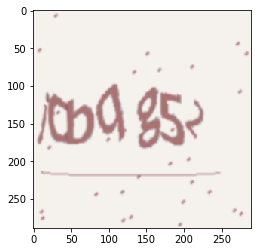

In [180]:
show_images_from_dataloader(images[0, :, :, :])

In [197]:
len(full_captcha_dataset_loader)

5

In [202]:
len(predictions_info)

1000